# Making Estimations with a NBA dataset

The goals of this project are:
- Define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.



### Analyzing data

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import imblearn
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)

1.1. All players statistics ("PTS", "REB", "AST","STL","BLK") against salary

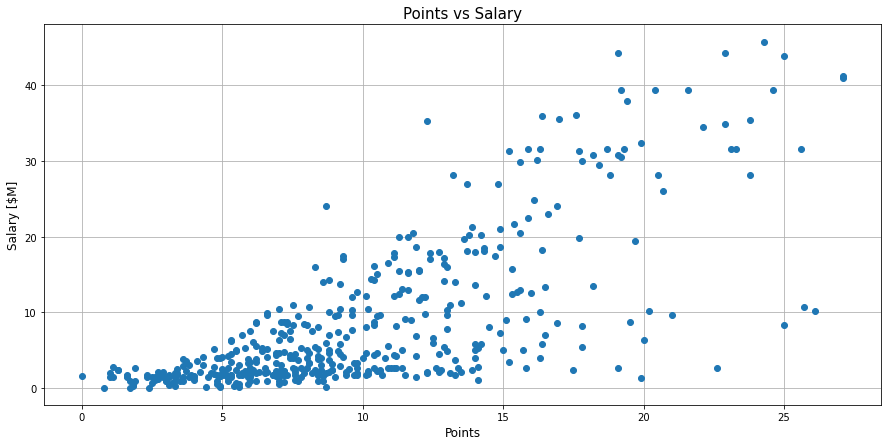

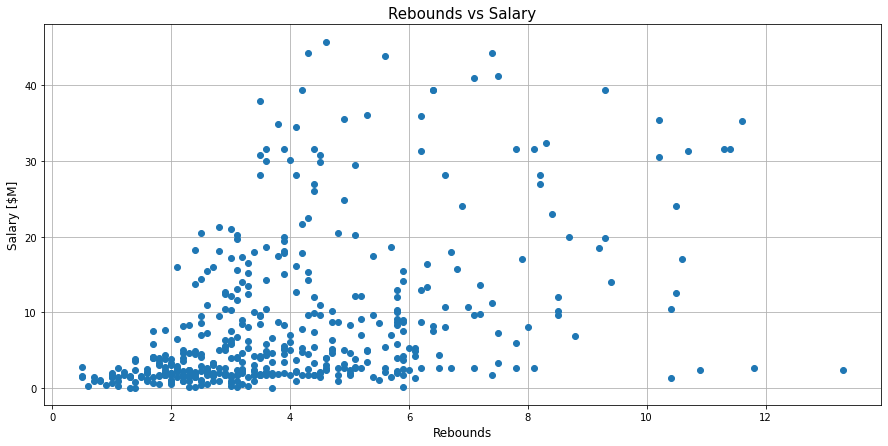

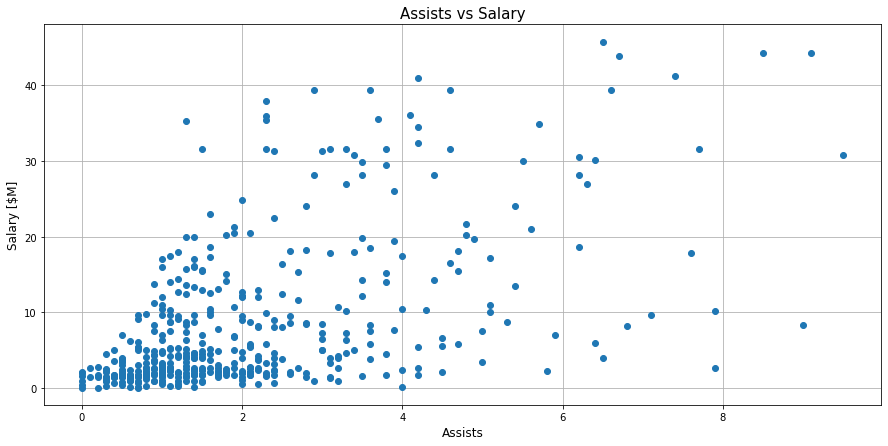

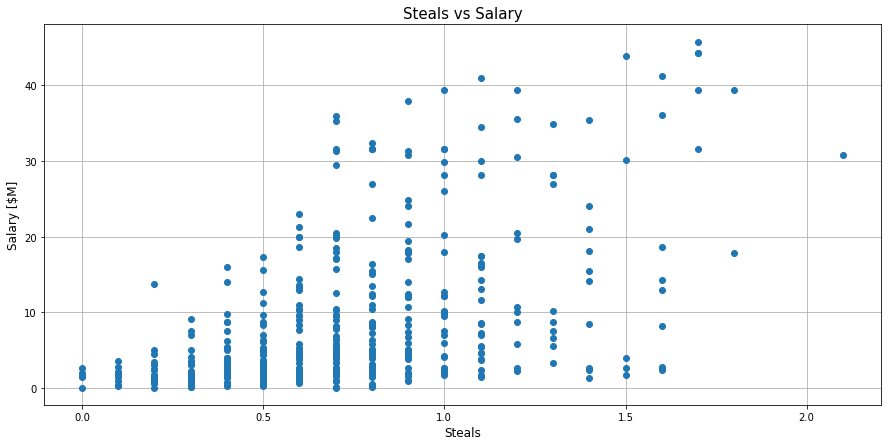

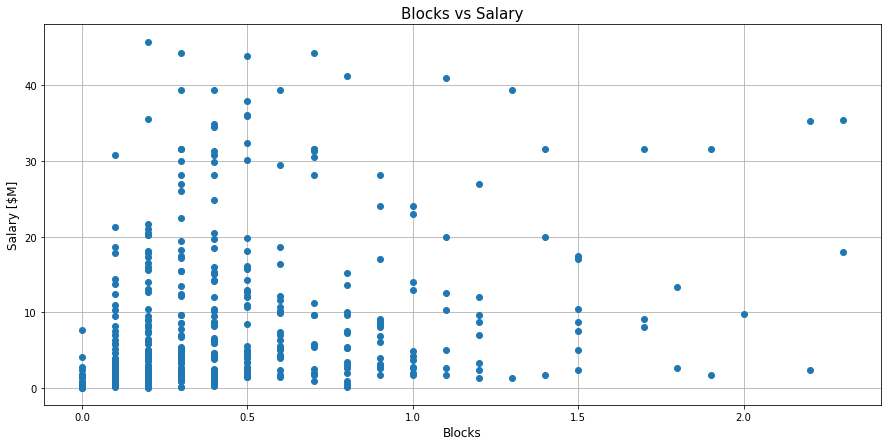

In [3]:
stats_dict = {"PTS": "Points", "REB": "Rebounds", "AST": "Assists","STL": "Steals","BLK": "Blocks"}
for stats in stats_dict:
    fig, ax = plt.subplots(figsize=(15, 7), facecolor='w')
    ax.plot(data[stats], data.Salary/1000000, '.', markersize=12)
    ax.set_title(stats_dict[stats]+' vs Salary', size=15)
    ax.set_xlabel(stats_dict[stats], size=12)
    ax.grid()
    ax.set_ylabel('Salary [$M]', size=12)
    plt.show()

1.2. Comments:  
*Points vs Salaries are the most correlated series. A significant correlation can be seen in that graph.  
*Rebounds vs Salaries and Assists vs Salaries are less correlated but still show some correlation.  
*Steals vs Salaries are slightly correlated (minimum)  
*There are no correlation in Blocks vs Salaries.  


### Splitting the Dataset

In [5]:
data_features = data.drop('Salary', axis=1).copy()
data_target   = data['Salary'].copy()
data_ft_train, data_ft_test, data_t_train, data_t_test = train_test_split(data_features, data_target, test_size=0.33, random_state=42)

### Baseline Model and Evaluation Metric

Baseline: average player salary.  
Evaluation Metric: Mean Absolute Error


1.4. Baseline model class that implements  fit() and predict() methods.

In [6]:
class BaselineModel():

    def fit(self, y_train):
        self.y_mean = y_train.mean()
        
    def predict(self, X):
        len_X  = len(X)
        return np.full(len_X, self.y_mean)
        

1.5. Evaluate the performance of the BaselineModel

In [7]:
base_line_model = BaselineModel()
base_line_model.fit(data_t_train)
baseline_mae = mean_absolute_error(data_t_test, base_line_model.predict(data_ft_test))
baseline_mae = round(baseline_mae,2)

### Regression with a single variable

1.6. Selecting the variable with the best fit.

In [8]:
scaler = StandardScaler()
scaler.fit(data_ft_train['PTS'].values.reshape(-1, 1))
data_ft_train['PTS'] = scaler.transform(data_ft_train['PTS'].values.reshape(-1, 1))
#Data set test, uses the scaler fitted with data set train
data_ft_test['PTS']  = scaler.transform(data_ft_test['PTS'].values.reshape(-1, 1))

1.7. Training a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluating the model's performance on the test set using the selected metric.

In [9]:
regressor = SGDRegressor()
regressor.fit(data_ft_train['PTS'].values.reshape(-1, 1), data_t_train)
predicted_salaries = regressor.predict(data_ft_test['PTS'].values.reshape(-1, 1))
default_mae = round(mean_absolute_error(data_t_test, predicted_salaries),2)

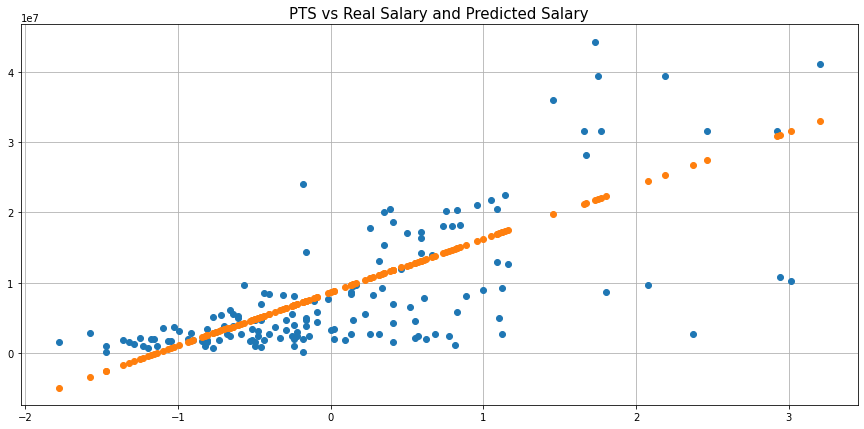

In [10]:
fig, ax = plt.subplots(figsize=(15, 7), facecolor='w')
ax.plot(data_ft_test['PTS'], data_t_test, '.', markersize=12)
ax.plot(data_ft_test['PTS'], predicted_salaries, '.', markersize=12)
ax.set_title('PTS vs Real Salary and Predicted Salary', size=15)
ax.grid()
plt.show()

1.8. Function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluates the trained algorithm on the test set, then saves the results of each hyperparameter combination, finally selects the one that has the best MAE (meaning the lowest number) and prints the combination and the MAE.

In [11]:
#This function iterates over the hiperparameter of SGDRegressor
#Support data sets with a single feature or multiple feature
#Returns the best mae obtained and its hiperparameters
def search_best_hyperparameters(max_iter, eta0, x_train, x_test, y_train, y_test, single_ft):
    result = {
        "hyperparameters": {"max_iter": None, "eta0": None}, 
        "mae": None
    }
    # Complete your code here
    list_mae=[]
    list_pars=[]
    for max_iter_v in max_iter:
        for eta0_v in eta0:
            regressor_i          = SGDRegressor(max_iter=max_iter_v, eta0=eta0_v)
            if single_ft:
                regressor_i.fit(x_train.values.reshape(-1, 1), y_train)
                predicted_salaries_i = regressor_i.predict(x_test.values.reshape(-1, 1))
            else:
                regressor_i.fit(x_train, y_train)
                predicted_salaries_i = regressor_i.predict(x_test)
            mae_i                = mean_absolute_error(y_test, predicted_salaries_i)
            list_mae.append(mae_i)
            list_pars.append([max_iter_v,eta0_v])
    index_min_mae                         = list_mae.index(min(list_mae))
    result["mae"]                         = list_mae[index_min_mae]
    result["hyperparameters"]["max_iter"] = list_pars[index_min_mae][0]
    result["hyperparameters"]["eta0"]     = list_pars[index_min_mae][1]
    return result

In [12]:
max_iter = [1000, 10000, 100000, 1000000]
eta0     = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
result   = search_best_hyperparameters(max_iter, eta0, data_ft_train['PTS'], data_ft_test['PTS'], data_t_train, data_t_test, 1)
best_mae = round(result['mae'],2)
print(result)

#Save data for latter usage (point 3)
data_ft_train_p3 = data_ft_train['PTS'].copy()
data_ft_test_p3  = data_ft_test['PTS'].copy()
data_t_train_p3  = data_t_train.copy()
data_t_test_p3   = data_t_test.copy()

{'hyperparameters': {'max_iter': 1000, 'eta0': 0.3}, 'mae': 4773695.7290350525}


1.9. Comparing the results.

In [13]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {best_mae}")

Mean Absolute Error for each model:
Baseline: 6932349.16
Default SGDRegressor: 4977291.47
Best SGDRegressor: 4773695.73


### Multivariate Linear Regression

To improve the model, more features are added to it:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Creating a copy of the dataset that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "SALARY"]

In [14]:
data         = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
columns_list = ["PERSON_ID", "PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "Salary", "TEAM_NAME"]
data_sel     = data[columns_list].copy()
data_sel.set_index("PERSON_ID", inplace=True)
data_sel.rename(columns={"Salary": "SALARY"}, inplace=True)

#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So bins are going to be divided like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted

In [15]:
#to int to apply cut and get the intervals
data_sel['DRAFT_NUMBER'] = data_sel.DRAFT_NUMBER.apply(lambda x: np.nan if x=='Undrafted' else x)
data_sel['DRAFT_NUMBER'] = data_sel.DRAFT_NUMBER.astype(float).astype('Int64')
bins = pd.IntervalIndex.from_tuples([(0, 15), (15, 30), (30, 60)])
data_sel['DRAFT'] = pd.cut(data_sel.DRAFT_NUMBER, bins)
#to str to replace for labels
data_sel['DRAFT'] = data_sel.DRAFT.astype(str)
dict = {"(0, 15]" : "firstround_lottery",
        "(15, 30]": "firstround_non_lottery",
        "(30, 60]": "second_round",
        pd.NA     : "undrafted"}
data_sel['DRAFT'].replace(dict, inplace=True)
data_sel.drop('DRAFT_NUMBER', axis=1, inplace=True)

1.12. Encoding the categorical features: DRAFT, POSITION and TEAM_NAME

In [16]:
columns_list = ["DRAFT", "POSITION", "TEAM_NAME"] 
data_sel.dropna(subset=columns_list, inplace=True) #only TEAM_NAME has empty data
enc = OneHotEncoder()
enc.fit(data_sel[columns_list])
enc_array    = enc.transform(data_sel[columns_list]).toarray()
enc_df       = pd.DataFrame(enc_array, columns=enc.get_feature_names())
enc_df.index = data_sel.index
data_sel     = pd.concat([data_sel, enc_df], axis=1)
data_sel.drop(columns_list, axis=1, inplace=True)

#### Modeling

1.13. Splitting the dataset into train and test

In [17]:
columns_list = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]
data_sel.dropna(subset=columns_list, inplace=True) #remove na before split
data_features = data_sel.drop('SALARY', axis=1).copy()
data_target   = data_sel['SALARY'].copy()
data_ft_train, data_ft_test, data_t_train, data_t_test = train_test_split(data_features.copy(), data_target.copy(), test_size=0.33, random_state=42)

1.14. Performing feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

In [18]:
for col in columns_list:
    scaler.fit(data_ft_train[col].values.reshape(-1, 1))
    data_ft_train[col] = scaler.transform(data_ft_train[col].values.reshape(-1, 1))
    data_ft_test[col]  = scaler.transform(data_ft_test[col].values.reshape(-1, 1))

1.15. Training a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [19]:
max_iter = [1000, 10000, 100000]
eta0     = [0.00001, 0.0001, 0.001, 0.01, 0.1]
result   = search_best_hyperparameters(max_iter, eta0, data_ft_train, data_ft_test, data_t_train, data_t_test, 0)
best_mv_mae = round(result['mae'],2)
print(result)

{'hyperparameters': {'max_iter': 1000, 'eta0': 0.0001}, 'mae': 4894600.496660885}


1.16. Comments:  
*A tiny variation is shown when univariate is compare to multivariate.   
*I've proved different combination of test_size and random_state in the split section.   
*Also diferent hiperparameters in each case.    
*With this changes different MAEs are obtained but the difference between uni and multvariate remain small.   
*In some cases multi variate performed better and in others it does not (compare with uni variate)   

### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Createing new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. Trying different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features


In [21]:
#This function iterates over the hiperparameter of DecisionTreeRegressor
#Returns the best mae obtained and its hiperparameters
def search_best_hyperparameters_tree(max_depth, min_samples_leaf, max_features, x_train, x_test, y_train, y_test):
    result = {
        "hyperparameters": {"max_depth": None, "min_samples_leaf": None, "max_features": None}, 
        "mae": None
    }
    # Complete your code here
    list_mae=[]
    list_pars=[]
    for max_depth_v in max_depth:
        for min_samples_leaf_v in min_samples_leaf:
            for max_features_v in max_features:
                tree_regr_i = DecisionTreeRegressor(max_depth=max_depth_v, min_samples_leaf=min_samples_leaf_v, max_features=max_features_v)
                tree_regr_i.fit(x_train, y_train)
                predicted_salaries_t = tree_regr_i.predict(x_test)
                mae_t                = mean_absolute_error(y_test, predicted_salaries_t)
                list_mae.append(mae_t)
                list_pars.append([max_depth_v,min_samples_leaf_v,max_features_v])
    index_min_mae                                 = list_mae.index(min(list_mae))
    result["mae"]                                 = list_mae[index_min_mae]
    result["hyperparameters"]["max_depth"]        = list_pars[index_min_mae][0]
    result["hyperparameters"]["min_samples_leaf"] = list_pars[index_min_mae][1]
    result["hyperparameters"]["max_features"]     = list_pars[index_min_mae][2]
    return result

In [22]:
# List of hyperparameter example values
max_depth        = [1, 5, 10, 15, 20, 50, 100]
min_samples_leaf = [1, 2, 10, 20, 50]
max_features     = [1, 5, 10, 20]

result = search_best_hyperparameters_tree(max_depth, min_samples_leaf, max_features, data_ft_train, data_ft_test, data_t_train, data_t_test)
best_mae_tree = round(result['mae'],2)
print(result)

{'hyperparameters': {'max_depth': 15, 'min_samples_leaf': 20, 'max_features': 20}, 'mae': 3579286.025741203}


1.18. Comparing the results.

In [23]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {best_mae}")
print(f"Best Multi Variate SGDRegressor: {best_mv_mae}")
print(f"Best Multi Variate DTRegressor: {best_mae_tree}")

Mean Absolute Error for each model:
Baseline: 6932349.16
Default SGDRegressor: 4977291.47
Best SGDRegressor: 4773695.73
Best Multi Variate SGDRegressor: 4894600.5
Best Multi Variate DTRegressor: 3579286.03


### Analyzing the results

1.19. Comments:    
*Non linear models (decision tree model) worked better in this dataset.   
*Hypothesis: Based on the observation of data none of the features have a stricly linear relationship with the salaries of the players.  
*Based on the read about players salaries, salaries depend on multiple factors and the combination of all the factor is not going to be linear with the salaries.   
   
To Improve:   
*Gathering more data (number of samples) may make a more robust prediction.
*Removing some features that dont have a relevant relationship with the salary (add noise instead of add certainty)   
*Adding new features that have a good relationship with the player salaries.   

## Star or no Star? Predicting players All-NBA selections

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so a classifier model going to be trained to solve this problem.

### Analyzing the data

To do this task, historical information about All-NBA selections is needed. A dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season is used.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be the target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Loading the dataset "all_nba_1990_2017_dataset.csv" from disk:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [26]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)
print("Number of rows:", len(all_nba_df))
print("Number of seasons:", all_nba_df.season.nunique())
print("Number of unique players:", all_nba_df.player_id.nunique())
print("Number of all-nba selections:", all_nba_df.all_nba.value_counts()[1])
print("Number of all-nba non selected:", all_nba_df.all_nba.value_counts()[0])

Number of rows: 14825
Number of seasons: 39
Number of unique players: 2718
Number of all-nba selections: 496
Number of all-nba non selected: 14329


### Splitting the dataset

In [27]:
columns_list = ['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
X_data = all_nba_df[columns_list].copy()
y_data = all_nba_df['all_nba'].copy()
#Splitting with stratify to keep the proportion of the target values
data_ft_train, data_ft_test, data_t_train, data_t_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42, stratify=y_data)

### Baseline model and Evaluation Metrics

Baseline: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [28]:
print("Accuracy of always predict 0:", round(data_t_train.value_counts()[0] / len(data_t_train) * 100,2), "%")

Accuracy of always predict 0: 96.66 %


2.4. Comments:   
As nba players that enter to all-NBA are the least, accuracy measured in all data set is not a good evaluation metric

2.5. Scaling all numerical features in the dataset

In [30]:
num_columns_list = data_ft_train.select_dtypes(include='number').columns.tolist()
scaler.fit(data_ft_train[num_columns_list])
data_ft_train[num_columns_list] = scaler.transform(data_ft_train[num_columns_list])
data_ft_test[num_columns_list]  = scaler.transform(data_ft_test[num_columns_list])

2.6. Training a LogisticRegression with default parameters, using only the numerical features (omitting the team information for now). This will be the baseline model. 

In [31]:
logistic_reg = LogisticRegression(random_state=0)
logistic_reg.fit(data_ft_train[num_columns_list], data_t_train)
log_reg_prediction = logistic_reg.predict(data_ft_test[num_columns_list])

2.7. Evaluating the baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [32]:
accuracy  = round(accuracy_score(data_t_test, log_reg_prediction),2)
metrics   = precision_recall_fscore_support(data_t_test, log_reg_prediction, average='binary')

precision = round(metrics[0],2)
recall    = round(metrics[1],2)
f1        = round(metrics[2],2)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("f1       :", f1)

Accuracy : 0.98
Precision: 0.78
Recall   : 0.59
f1       : 0.67


### Classification

#### Feature engineering

2.8. One hot encoding the Team feature.

In [33]:
enc = OneHotEncoder()
enc.fit(data_ft_train['team'].values.reshape(-1,1))
#Train
enc_array     = enc.transform(data_ft_train['team'].values.reshape(-1,1)).toarray()
enc_df        = pd.DataFrame(enc_array, columns=enc.get_feature_names())
enc_df.index  = data_ft_train.index
data_ft_train = pd.concat([data_ft_train, enc_df], axis=1)
data_ft_train.drop('team', axis=1, inplace=True)
#Test
enc_array     = enc.transform(data_ft_test['team'].values.reshape(-1,1)).toarray()
enc_df        = pd.DataFrame(enc_array, columns=enc.get_feature_names())
enc_df.index  = data_ft_test.index
data_ft_test  = pd.concat([data_ft_test, enc_df], axis=1)
data_ft_test.drop('team', axis=1, inplace=True)

#### Modeling

2.9. Training a logistic regresion model, finding the best hyperparameters for: tols, C and max_iter.

In [34]:
#This function iterates over the hiperparameter of LogisticRegression
#Selects the best model based on f1 metric
#Returns precision, recall and f1 metrics. Returns the hiperparameter of the model. And returns the model itself.
def search_best_hyperparameters_log(max_iter, tol, C, x_train, x_test, y_train, y_test):
    result = {
        "hyperparameters": {"max_iter": None, "tol": None, "C": None}, 
        "scores": {"precision": None, "recall": None, "f1": None},
        "model": None
    }
    # Complete your code here
    list_f1  =[]
    list_rest=[]
    for max_iter_v in max_iter:
        for tol_v in tol:
            for C_v in C:
                log_regr_i     = LogisticRegression(random_state=0, max_iter=max_iter_v, tol=tol_v, C=C_v)
                log_regr_i.fit(x_train, y_train)
                log_reg_pred_i = log_regr_i.predict(x_test)
                metrics_i      = precision_recall_fscore_support(y_test, log_reg_pred_i, average='binary')
                precision_i    = round(metrics_i[0],2)
                recall_i       = round(metrics_i[1],2)
                f1_i           = round(metrics_i[2],2)
                
                list_f1.append(f1_i)
                list_rest.append([max_iter_v,tol_v,C_v,precision_i,recall_i, log_regr_i])
    index_max_f1                            = list_f1.index(max(list_f1))
    result["hyperparameters"]["max_iter"]   = list_rest[index_max_f1][0]
    result["hyperparameters"]["tol"]        = list_rest[index_max_f1][1]
    result["hyperparameters"]["C"]          = list_rest[index_max_f1][2]
    result["scores"]["precision"]           = list_rest[index_max_f1][3]
    result["scores"]["recall"]              = list_rest[index_max_f1][4]
    result["scores"]["f1"]                  = list_f1[index_max_f1]
    result["model"]                         = list_rest[index_max_f1][5]
    return result

In [35]:
max_iter_list = [1000, 5000, 10000, 15000]
tol_list      = [1e-11, 1e-9, 1e-7, 1e-5]
C_list        = [1, 1.5, 2, 2.5]

log_pred_results = search_best_hyperparameters_log(max_iter_list, tol_list, C_list, data_ft_train, data_ft_test, data_t_train, data_t_test)

print(log_pred_results)

{'hyperparameters': {'max_iter': 1000, 'tol': 1e-11, 'C': 1}, 'scores': {'precision': 0.84, 'recall': 0.62, 'f1': 0.71}, 'model': LogisticRegression(C=1, max_iter=1000, random_state=0, tol=1e-11)}


#### Evaluating on New Data

In [36]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

#Scaling
players_df = all_nba_2018_df['player'].copy()
all_nba_2018_df.drop(['season_id', 'player_id', 'player_season', 'player', 'season', 'season_start'], axis=1, inplace=True)
cols_to_scale = all_nba_2018_df.drop(['team'], axis=1).columns.to_list()
all_nba_2018_df[cols_to_scale] = scaler.transform(all_nba_2018_df[cols_to_scale])

#Encoding 
#encoder (one hot encoder) create the amount of columns set in fit(). And fill the non-used with 0
enc_array       = enc.transform(all_nba_2018_df['team'].values.reshape(-1,1)).toarray()
enc_df          = pd.DataFrame(enc_array, columns=enc.get_feature_names())
enc_df.index    = all_nba_2018_df.index
all_nba_2018_df = pd.concat([all_nba_2018_df, enc_df], axis=1)
all_nba_2018_df.drop('team', axis=1, inplace=True)

2.11. Predicting and evaluating the model using precision, recall and f1 score. 

In [37]:
log_reg_pred = log_pred_results['model'].predict(all_nba_2018_df)

metrics      = precision_recall_fscore_support(all_nba_2018_selections['all_nba'], log_reg_pred, average='binary')
precision    = round(metrics[0],2)
recall       = round(metrics[1],2)
f1           = round(metrics[2],2)

print("Precision:", precision)
print("Recall   :", recall)
print("f1       :", f1)

Precision: 0.62
Recall   : 1.0
f1       : 0.77


2.12. Comments:   
*As the test dataset is highly unbalaced on the target column, there are no false negatives, therefore recall=1   
*For the same reason (unbalanced data set) precision is lower than the one obtained over the validation data set


#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But the current model does not limit the number of positive classified players. So, it is needed to wrap the model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 

2.13. Using the trained model and predicting probabilities for all rows in the dataset

In [39]:
prob_array      = log_pred_results['model'].predict_proba(all_nba_2018_df)
prob_array      = np.around(prob_array,decimals=3)
prob_df         = pd.DataFrame(prob_array)
prob_df.index   = all_nba_2018_df.index
all_nba_2018_df_w_prob = pd.concat([all_nba_2018_df, prob_df[1]], axis=1)
all_nba_2018_df_w_prob.rename(columns={1: "All-NBA-Prob"}, inplace=True)

2.14. Sorting the dataset by probabilities and showing the 15 players with higher probability to have been selected

In [40]:
all_nba_2018_df_w_players = pd.concat([all_nba_2018_df_w_prob, players_df], axis=1)
all_nba_2018_df_w_players.sort_values('All-NBA-Prob', ascending=False, inplace=True)
print(all_nba_2018_df_w_players[['player', 'All-NBA-Prob']].head(15))

                      player  All-NBA-Prob
453    Giannis Antetokounmpo         0.999
5604            James Harden         0.999
6857            LeBron James         0.997
3401           Anthony Davis         0.985
14479      Russell Westbrook         0.979
4145             Joel Embiid         0.975
14027         Nikola Vucevic         0.972
3908            Kevin Durant         0.965
4895             Paul George         0.946
8206          Damian Lillard         0.876
8103           Kawhi Leonard         0.872
168        LaMarcus Aldridge         0.863
5399           Blake Griffin         0.850
13673     Karl-Anthony Towns         0.845
5016             Rudy Gobert         0.831


2.15. Printing:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [41]:
#Create a df with all data
#including our prediction
log_reg_pred_df           = pd.DataFrame(log_reg_pred)
log_reg_pred_df.index     = all_nba_2018_df.index #index from all_nba_2018_df because all_nba_2018_df_w_players was sorted by prob
all_nba_2018_df_w_predict = pd.concat([all_nba_2018_df_w_players, log_reg_pred_df], axis=1)
all_nba_2018_df_w_predict.rename(columns={0: "Prediction"}, inplace=True)

#including real result
all_nba_2018_df_w_predict = pd.concat([all_nba_2018_df_w_predict, all_nba_2018_selections['all_nba']], axis=1)
all_nba_2018_df_w_predict.rename(columns={"all_nba": "all_nba_real"}, inplace=True)

print("***** Players actually selected from the all_nba_2018_selections dataset ******")
print(all_nba_2018_df_w_predict['player'].loc[all_nba_2018_df_w_predict.all_nba_real == 1])

print("\n***** Players actually selected missing from OUR predictions ******")
mask = (all_nba_2018_df_w_predict.all_nba_real == 1) & (all_nba_2018_df_w_predict.Prediction == 0)
if all_nba_2018_df_w_predict[mask].empty:
    print("\n# All players actually selected were predicted as selected")
else:
    print(all_nba_2018_df_w_predict[mask])

print("\n***** Players in our predictions not selected  ******")
mask = (all_nba_2018_df_w_predict.all_nba_real == 0) & (all_nba_2018_df_w_predict.Prediction == 1)
if all_nba_2018_df_w_predict[mask].empty:
    print("\n# All players predicted as selected were actually selected")
else:
    print(all_nba_2018_df_w_predict[mask]['player'])

***** Players actually selected from the all_nba_2018_selections dataset ******
453      Giannis Antetokounmpo
3168             Stephen Curry
3908              Kevin Durant
4145               Joel Embiid
4895               Paul George
5016               Rudy Gobert
5399             Blake Griffin
5604              James Harden
6634              Kyrie Irving
6857              LeBron James
7225              Nikola Jokic
8103             Kawhi Leonard
8206            Damian Lillard
14132             Kemba Walker
14479        Russell Westbrook
Name: player, dtype: object

***** Players actually selected missing from OUR predictions ******

# All players actually selected were predicted as selected

***** Players in our predictions not selected  ******
168       LaMarcus Aldridge
1048           Bradley Beal
2274           Clint Capela
3401          Anthony Davis
3538          DeMar DeRozan
3794         Andre Drummond
12473           Ben Simmons
13673    Karl-Anthony Towns
14027        Nikola

2.16. Creating a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [42]:
class AllNbaSingleSeasonClassifier():
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        self._model = model
        
    def predict(self, X):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results based on the players with most probabilities of
            beign selected
        """
        custom_class_pred = self._model.predict_proba(X)
        custom_class_pred_df = pd.DataFrame(custom_class_pred)
        custom_class_pred_df.drop(0, inplace=True, axis=1)
        #Rank all the probabilities values
        custom_class_pred_df = custom_class_pred_df.rank(ascending=False)
        #set 1 to the 15 best probabilities and 0 to the rest
        custom_class_pred_df = custom_class_pred_df[1].apply(lambda x: 1 if x<=15 else 0)        
        return custom_class_pred_df.to_numpy()

2.17. Using the new classifier to make predictions and evaluate the result with precision, recall and f1

In [43]:
custom_classifier = AllNbaSingleSeasonClassifier(log_pred_results['model'])

custom_log_reg_pred = custom_classifier.predict(all_nba_2018_df)

metrics      = precision_recall_fscore_support(all_nba_2018_selections['all_nba'], custom_log_reg_pred, average='binary')
precision    = round(metrics[0],2)
recall       = round(metrics[1],2)
f1           = round(metrics[2],2)

print("Precision:", precision)
print("Recall   :", recall)
print("f1       :", f1)

Precision: 0.73
Recall   : 0.73
f1       : 0.73


#### Analyzing our results

2.18. Comments:    
*Data sets is highly unbalanced in target values.   
*Besides, the number of 'True labels' is very low so it's difficult to get a reliable statistic out of it

To improve:   
*Turn the unbalanced data set to an balanced data set. 
*We could get more samples in order to improve the statistics.
*Doing the classification of the 15 players filtering by position. This could enhance the selection.

### Oversampling

In [46]:
#Oversampling data set to get balanced data sets
sm = SMOTE(random_state=42)
data_ft_train_res, data_t_train_res = sm.fit_resample(data_ft_train, data_t_train)

#Retraining the model
log_pred_results['model'].fit(data_ft_train_res, data_t_train_res)

#Prediction with custom classifier Class
custom_classifier_ov   = AllNbaSingleSeasonClassifier(log_pred_results['model'])
custom_log_reg_pred_ov = custom_classifier_ov.predict(all_nba_2018_df)

#Metrics
metrics_ov      = precision_recall_fscore_support(all_nba_2018_selections['all_nba'], custom_log_reg_pred_ov, average='binary')
precision_ov    = round(metrics_ov[0],2)
recall_ov       = round(metrics_ov[1],2)
f1_ov           = round(metrics_ov[2],2)

print("Unbalanced Precision:", precision, "--- Balanced Precision:",  precision_ov)
print("Unbalanced Recall   :", recall,    "--- Balanced Recall   :",  recall_ov)
print("Unbalanced f1       :", f1,        "--- Balanced f1       :",  f1_ov)

Unbalanced Precision: 0.73 --- Balanced Precision: 0.8
Unbalanced Recall   : 0.73 --- Balanced Recall   : 0.8
Unbalanced f1       : 0.73 --- Balanced f1       : 0.8


## Developing a Linear Regressor class from scratch

3.1. Writing a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [47]:
class LinearRegressor:
    """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
    
    def __init__(self, epochs: int, learning_rate: float):
        """
        Class constructor
        
        Parameters
        ----------
        epochs: int
            number of epochs to run gradient descent
        learning_rate: float
            rate of update of the gradients
        """
        self._epochs = epochs
        self._lr     = learning_rate
        self.w0      = 10 #arbitrary data
        self.w1      = 10 #arbitrary data


    def _gradient_descent(self, X, y):
        """
        Gradient descent algorithm
        """
        deriv_Lw0 = ((self.predict(X)-y) * 1).sum() / len(X)
        deriv_Lw1 = ((self.predict(X)-y) * X).sum() / len(X)
        w0_tmp    = self.w0 - self._lr * deriv_Lw0
        w1_tmp    = self.w1 - self._lr * deriv_Lw1
        
        self.w0 = w0_tmp
        self.w1 = w1_tmp

    def fit(self, X, y):
        """
        Fit the model according to the given training data.
        
        Parameters
        ----------
        X: np.ndarray
        y: np.ndarray
        """
        for e in range(self._epochs):
            self._gradient_descent(X, y)
             
    def predict(self, X):
        """
        Predict
        
        Parameters
        ----------
        X: np.ndarray
        
        Returns
        -------
        np.ndarray
            array with predictions
        """
        return X * self.w1 + self.w0

3.2. Training a regression model with the data from the first section to calculate players salaries using points per game. 

In [48]:
#This function iterates over the hiperparameter of LinearRegressor.
#Returns the best mae. Returns the hiperparameter of the model.
def search_best_hyperparameters_manual(epochs, learning_rate, x_train, x_test, y_train, y_test):
    result = {
        "hyperparameters": {"epochs": None, "learning_rate": None},
        "mae": None       
    }
    # Complete your code here
    list_mae =[]
    list_rest=[]
    for epochs_v in epochs:
        for learning_rate_v in learning_rate:
            manual_LR_i       = LinearRegressor(epochs=epochs_v, learning_rate=learning_rate_v)
            manual_LR_i.fit(x_train, y_train)
            manual_pred_sal_i = manual_LR_i.predict(x_test)
            manual_mae_i      = mean_absolute_error(y_test, manual_pred_sal_i)
            list_mae.append(manual_mae_i)
            list_rest.append([epochs_v,learning_rate_v])
    index_min_mae                              = list_mae.index(min(list_mae))
    result["hyperparameters"]["epochs"]        = list_rest[index_min_mae][0]
    result["hyperparameters"]["learning_rate"] = list_rest[index_min_mae][1]
    result["mae"]                              = list_mae[index_min_mae]
    return result

epochs_list = [1000, 5000, 10000, 15000]
lr_list     = [0.01, 0.001, 0.0001, 0.00001]

manual_pred_results = search_best_hyperparameters_manual(epochs_list, lr_list, data_ft_train_p3.to_numpy(), data_ft_test_p3.to_numpy(), data_t_train_p3.to_numpy(), data_t_test_p3.to_numpy())

print(manual_pred_results["hyperparameters"])

{'epochs': 15000, 'learning_rate': 0.0001}


3.3. Evaluating the model performance on the test set, and comparing with the result you obtained using SGDRegressor from scikit-learn.

In [49]:
print("SGDRegressor from scikit-learn MAE:", best_mae)
print("Manual Linear Regressor MAE       :", round(manual_pred_results["mae"],2))

SGDRegressor from scikit-learn MAE: 4773695.73
Manual Linear Regressor MAE       : 4810506.75
